# iLykei Lecture Series 

# Machine Learning

# Decision Trees

# Workshop 2    

## Y.Balasanov, L.Nazarov &copy; iLykei 2017-22

Import necessary packages.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from io import StringIO  
import pydotplus
from IPython.display import Image
from matplotlib import pyplot as plt


# Regression Trees


Denote for the node $T$  

* $Y_T$ - the set of target variable values in $T$;
* $\overline{y}_{T}=\frac{1}{\left\vert Y_{T}\right\vert }\sum_{y\in
Y_{T}}y$ - the average of the target variable in $T$;
* $SS_{T}=\sum_{y\in Y_{T}}(y-\overline{y}_{T})^{2}$ - the sum of residuals' squares for $T$.

Regression trees use splitting criterion different from classification ones. In the `anova` method the splitting criteria is $$SS_T - (SS_L + SS_R)$$ where $SS_L$ and $SS_R$ are the sums of squares for the left and right son of $T$ respectively.  
The `anova` method leads to regression trees; it is the default method if target variable is a simple numeric vector, i.e., not a factor, matrix, or survival object.

Example from Section 8.1.1 of ISLR: Predicting Baseball Players' Salaries
-----------

Use the Hitters data from the ISLR library for a simple example

In [2]:
# Read and remove incomplete cases 
df = pd.read_csv('Hitters.csv',index_col=0).dropna()
df.head(3)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N


Predict a baseball player's `Salary` based on the number of `Years` spent in the major league, and the number of `Hits` in the previous year.    
Salary is measured in thousands of dollars.     


Fit the model, restricting the minimum number of samples a leaf node must have.

In [3]:
X = df[['Hits','Years']]
y = df.Salary
regr = DecisionTreeRegressor(random_state=0,min_samples_leaf=20)
salaryFit = regr.fit(X,y)

The regression tree can be visualized with the following function.

In [4]:
def plot_tree(estimator,feature_names):
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data,feature_names=feature_names,
                   rounded=True,filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

Function *export_graphviz* generates a GraphViz representation of the decision tree, which is then written into out_file in DOT format; *graph_from_dot_data* load it and *IPython.display.Image* creates an image object.  
Plot the tree for our model.

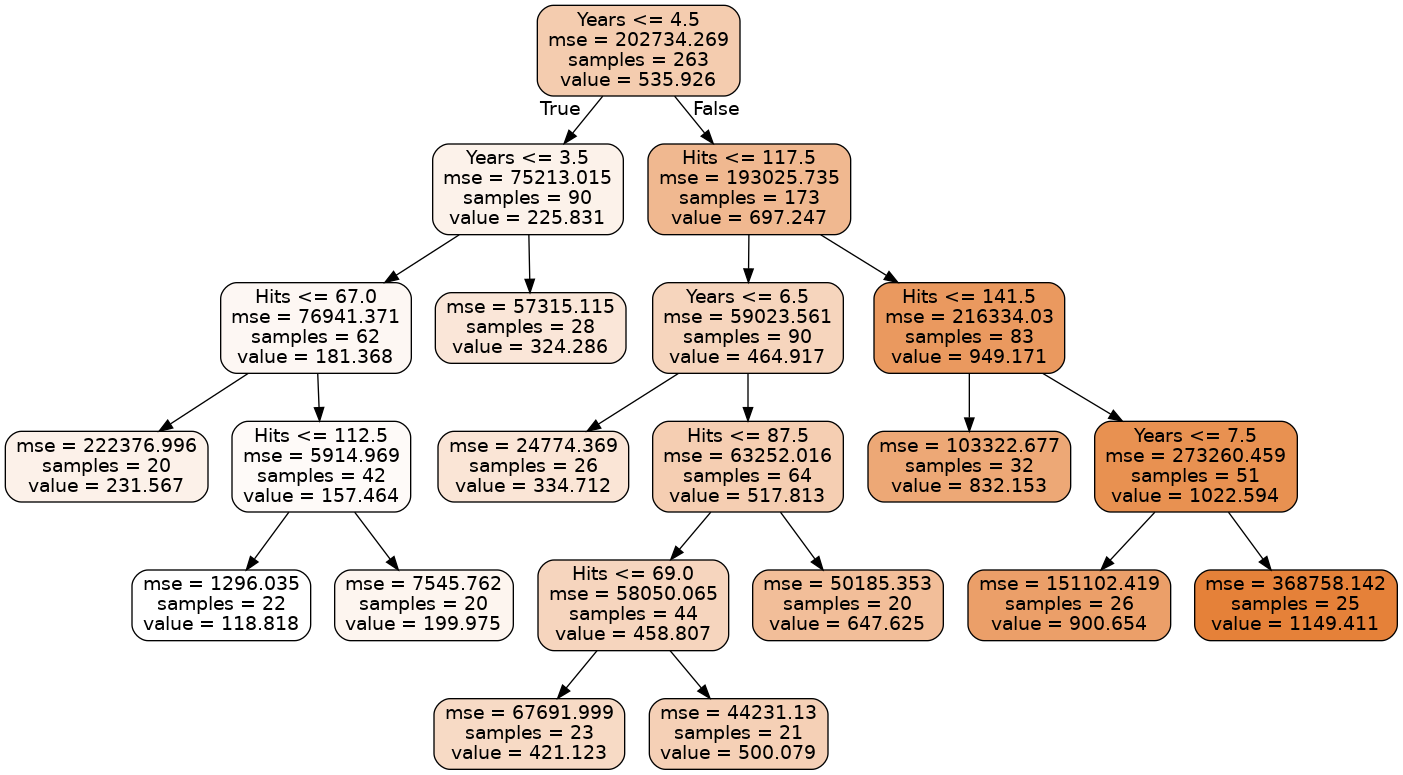

In [5]:
plot_tree(regr,list(X))

You see that the color intensity corresponds to the model prediction value for the node.

**Pruning**    

[Scikit-learn documentation](http://scikit-learn.org/stable/modules/tree.html#tree) points out that decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning (removing some nodes), setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.   
Unfortunately pruning is not currently supported in Scikit-learn. Nevertheless we can optimize model parameters using cross validation. The function below returns validation score (in our case this is coefficient of determination $R^2$ of the prediction) for 10-fold cross validation.

In [6]:
cross_val_score(regr, X, y, cv=10)

array([0.03564626, 0.75315465, 0.40901271, 0.44753337, 0.39518032,
       0.41872239, 0.13338317, 0.32010218, 0.02762879, 0.45452121])

Maximize CV score on the greed.

In [7]:
greed = np.arange(20,90,5)
CV_error = np.zeros(len(greed))
for i,nb_samples in enumerate(greed):
    regr = DecisionTreeRegressor(random_state=0,min_samples_leaf=nb_samples)
    CV_error[i] = np.mean(cross_val_score(regr, X, y, cv=10))
    print('min_samples_leaf = ',nb_samples,' CV error =',CV_error[i])

min_samples_leaf =  20  CV error = 0.33948850252738616
min_samples_leaf =  25  CV error = 0.3390685162594349
min_samples_leaf =  30  CV error = 0.3407278536180682
min_samples_leaf =  35  CV error = 0.35157999581106836
min_samples_leaf =  40  CV error = 0.40683169205267644
min_samples_leaf =  45  CV error = 0.40206898686931253
min_samples_leaf =  50  CV error = 0.40206898686931253
min_samples_leaf =  55  CV error = 0.40206898686931253
min_samples_leaf =  60  CV error = 0.40206898686931253
min_samples_leaf =  65  CV error = 0.40206898686931253
min_samples_leaf =  70  CV error = 0.40210585405918764
min_samples_leaf =  75  CV error = 0.401690468997693
min_samples_leaf =  80  CV error = 0.14829469343934615
min_samples_leaf =  85  CV error = 0.08530235379697299


We get smaller tree with the optimal number of *min_samples_leaf*.

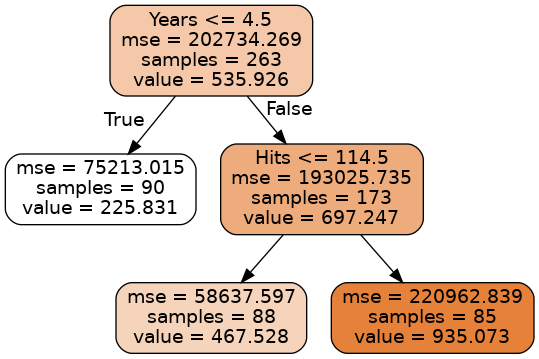

In [8]:
regr = DecisionTreeRegressor(random_state=0,
                             min_samples_leaf=greed[np.argmin(CV_error)])
regr.fit(X,y)
plot_tree(regr,list(X))

It separates players by experience, then further splits more experienced group by number of hits.  

The same procedure can be applied to the other parameters tunning.  

After the model is optimized forecasting is done by averaging the output (salary) based on mean values of tree leafs.    

Finally, it is possible to look at the residuals from this model, just as with a regular linear regression fit

<AxesSubplot:>

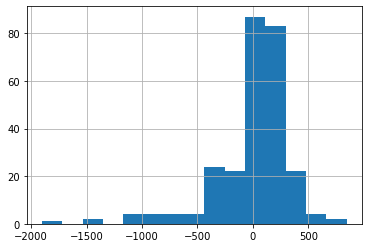

In [9]:
residuals = pd.Series(regr.predict(X)-y)
residuals.hist(bins=15)

Find the root mean squared error of prediction.

In [10]:
print('RMSE = ', np.sqrt(np.mean(residuals**2)))

RMSE =  341.71965696813186


Examples from introduction to the R `rpart` package
---------------------------------------

The following examples are from the [long introduction](https://cran.r-project.org/web/packages/rpart/vignettes/longintro.pdf) to R `rpart`.  

## Introduction to main functions: Cars    

The dataset `car90` contains a collection of variables from the April, 1990 Consumer Reports;
it has 34 variables on 111 cars.    
Variables tire size and model name are excluded because they are factors with a very large number of levels which creates a very long printout, and rim size because it is too good a predictor of price and leads to a less interesting illustration.  (Tiny cars are cheaper and have small rims.)

In [11]:
cars = pd.read_csv('car90.csv',index_col=0).drop(["Rim", "Tires", "Model2"],axis=1)
print(cars.info())
print(cars.head(3))

<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, Acura Integra to Volvo 740
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       105 non-null    object 
 1   Disp          108 non-null    float64
 2   Disp2         108 non-null    float64
 3   Eng.Rev       73 non-null     float64
 4   Front.Hd      111 non-null    float64
 5   Frt.Leg.Room  111 non-null    float64
 6   Frt.Shld      111 non-null    float64
 7   Gear.Ratio    73 non-null     float64
 8   Gear2         103 non-null    float64
 9   HP            108 non-null    float64
 10  HP.revs       108 non-null    float64
 11  Height        111 non-null    float64
 12  Length        111 non-null    int64  
 13  Luggage       111 non-null    int64  
 14  Mileage       53 non-null     float64
 15  Price         105 non-null    float64
 16  Rear.Hd       111 non-null    float64
 17  Rear.Seating  111 non-null    float64
 18  RearShld      111

We cannot feed the data directly to DecisionTreeRegressor. It does not accept  missing values and categorical variables. Replace missing values by *-1* and by  '-' for string columns.

In [12]:
cars.loc[:,cars.dtypes == 'object'] = cars.loc[:,cars.dtypes == 'object'].fillna('-') 
cars.fillna(-1,inplace=True)
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, Acura Integra to Volvo 740
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       111 non-null    object 
 1   Disp          111 non-null    float64
 2   Disp2         111 non-null    float64
 3   Eng.Rev       111 non-null    float64
 4   Front.Hd      111 non-null    float64
 5   Frt.Leg.Room  111 non-null    float64
 6   Frt.Shld      111 non-null    float64
 7   Gear.Ratio    111 non-null    float64
 8   Gear2         111 non-null    float64
 9   HP            111 non-null    float64
 10  HP.revs       111 non-null    float64
 11  Height        111 non-null    float64
 12  Length        111 non-null    int64  
 13  Luggage       111 non-null    int64  
 14  Mileage       111 non-null    float64
 15  Price         111 non-null    float64
 16  Rear.Hd       111 non-null    float64
 17  Rear.Seating  111 non-null    float64
 18  RearShld      111

No missing values anymore. Now convert categorical features to integer ones using *LabelEncoder*.

In [13]:
X = cars.drop('Price',axis=1).copy()
y = cars.Price/1000
cat_features = X.columns.values[X.dtypes == 'object']
print('Before encoding \n',X[cat_features].head())
X[cat_features] = X[cat_features].apply(LabelEncoder().fit_transform)
print('After encoding \n',X[cat_features].head())

Before encoding 
                Country  Reliability Steering Trans1  Trans2     Type
Acura Integra    Japan  Much better    power  man.5  auto.4    Small
Acura Legend     Japan  Much better    power  man.5  auto.4   Medium
Audi 100       Germany            -    power  man.5  auto.3   Medium
Audi 80        Germany            -    power  man.5  auto.3  Compact
BMW 325i       Germany       better    power  man.5  auto.4  Compact
After encoding 
                Country  Reliability  Steering  Trans1  Trans2  Type
Acura Integra        5            1         3       2       2     4
Acura Legend         5            1         3       2       2     3
Audi 100             4            0         3       2       1     3
Audi 80              4            0         3       2       1     1
BMW 325i             4            4         3       2       2     1


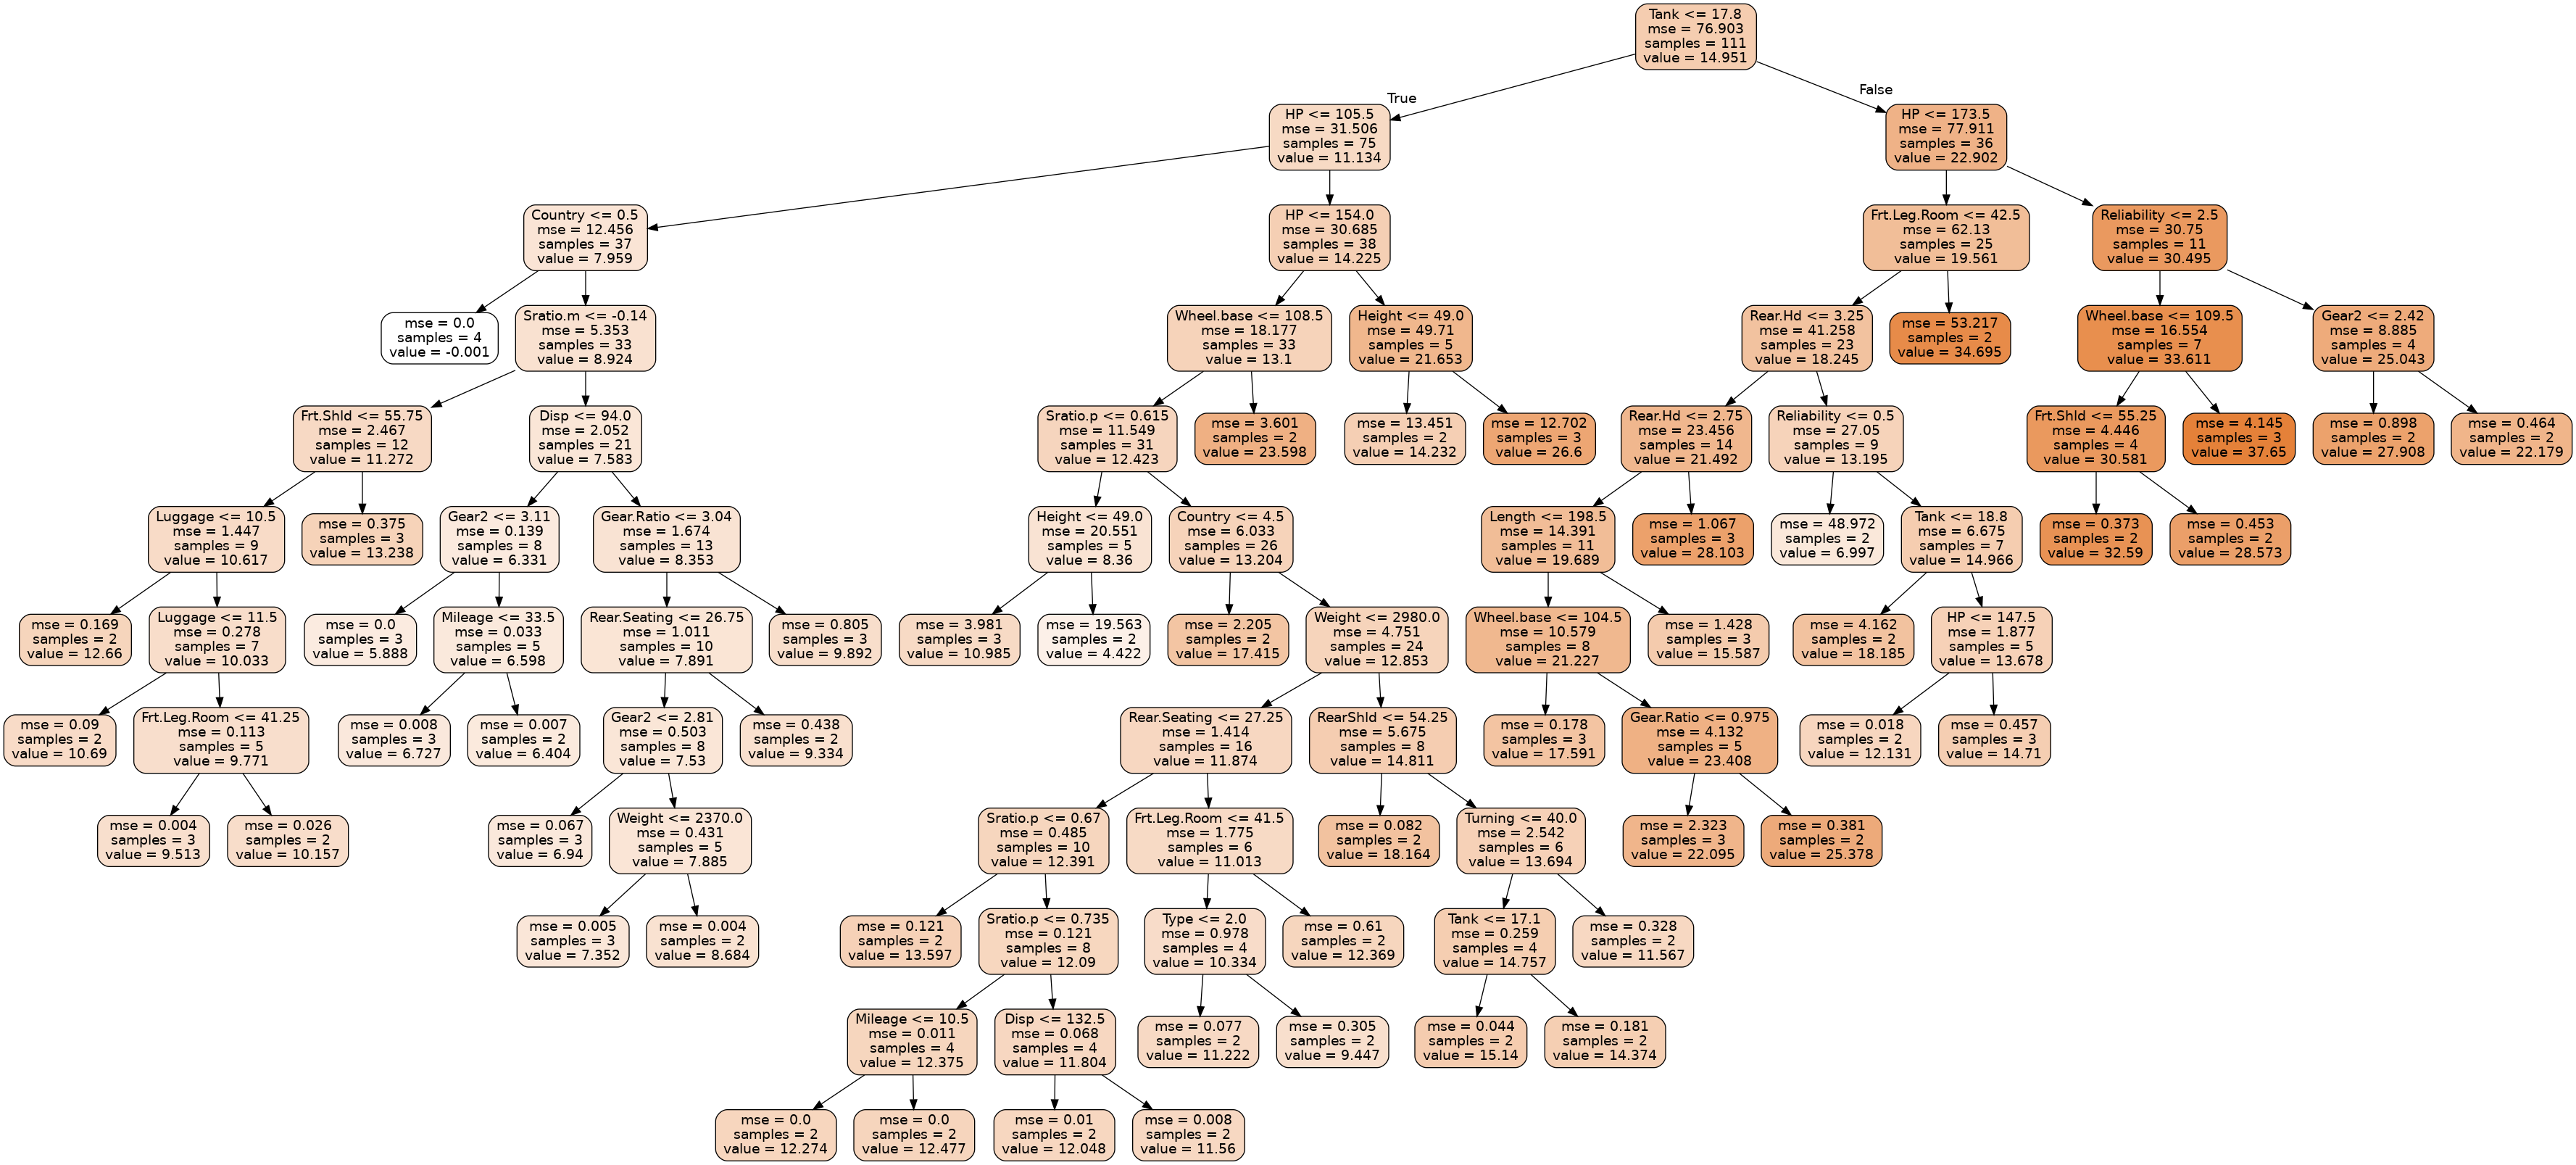

In [14]:
# Pruning not supported. Limit min_samples_leaf.
regr = DecisionTreeRegressor(random_state=0,min_samples_leaf=2)
regr.fit(X,y)
plot_tree(regr,list(X))

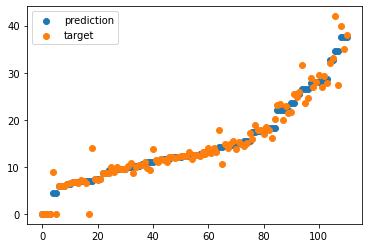

In [15]:
compare = pd.DataFrame({'target':y,'prediction':regr.predict(X)})
compare = compare.sort_values('prediction').reset_index()
ax = plt.scatter(x=compare.index, y=compare.prediction)
ax1 = plt.scatter(x=compare.index, y=compare.target)
plt.legend([ax,ax1],['prediction','target'])
plt.show()

We have already shown the way of tunning model hyperparameters running the function *cross_val_score* on the greed. Scikit-learn provides special tool for solving this probelem - *GridSearchCV*. In the following cell we find the pair of parameters ('max_depth','min_samples_leaf') minimizing MSE on validation set using 10-fold cross validation.

In [16]:
# define search area
greed = {'max_depth':range(2,5), 'min_samples_leaf': range(1,6)}
regr = DecisionTreeRegressor(random_state=0)
# We set negative MSE as scoring function since GridSearchCV maximizes scoring. 
grid_search = GridSearchCV(regr, greed,cv=10, scoring = 'neg_mean_squared_error')
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']  
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (-mean, param)) # recall that mean is negative MSE

Best: 62.362663 using {'max_depth': 4, 'min_samples_leaf': 2}
66.921559 with: {'max_depth': 2, 'min_samples_leaf': 1}
66.921559 with: {'max_depth': 2, 'min_samples_leaf': 2}
65.853092 with: {'max_depth': 2, 'min_samples_leaf': 3}
65.853092 with: {'max_depth': 2, 'min_samples_leaf': 4}
65.853092 with: {'max_depth': 2, 'min_samples_leaf': 5}
71.452146 with: {'max_depth': 3, 'min_samples_leaf': 1}
72.267457 with: {'max_depth': 3, 'min_samples_leaf': 2}
71.281991 with: {'max_depth': 3, 'min_samples_leaf': 3}
68.993857 with: {'max_depth': 3, 'min_samples_leaf': 4}
68.412047 with: {'max_depth': 3, 'min_samples_leaf': 5}
67.415200 with: {'max_depth': 4, 'min_samples_leaf': 1}
62.362663 with: {'max_depth': 4, 'min_samples_leaf': 2}
65.597506 with: {'max_depth': 4, 'min_samples_leaf': 3}
67.339100 with: {'max_depth': 4, 'min_samples_leaf': 4}
62.830636 with: {'max_depth': 4, 'min_samples_leaf': 5}


Plot true and predicted price values for optimized model on the train set $X$.

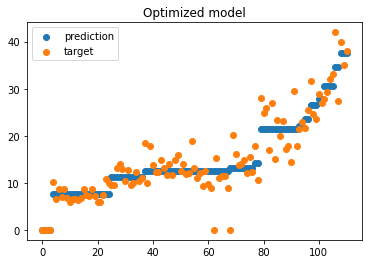

In [17]:
compare = pd.DataFrame({'target':y,'prediction':grid_result.predict(X)})
compare = compare.sort_values('prediction').reset_index()
ax = plt.scatter(x=compare.index, y=compare.prediction)
ax1 = plt.scatter(x=compare.index, y=compare.target)
plt.title('Optimized model')
plt.legend([ax,ax1],['prediction','target'])
plt.show()

You see that compare to the previous plot optimized model prediction function has less stairs (i.e. tree leaves) and worse RMSE on the train set, but reduced tree depth makes for better generalisation:

In [18]:
print('Initial model CV RMSE =',np.sqrt(-np.mean(cross_val_score(regr, X, y, 
                        scoring='neg_mean_squared_error',cv=10))))
print('Optimized model CV RMSE =',np.sqrt(-grid_result.best_score_))

Initial model CV RMSE = 8.261622586521442
Optimized model CV RMSE = 7.897003391320315


# Time series of stock prices     

Predict returns of exchange traded fund SPY representing S&P 500 with a group of stock returns of companies in the index.  
Select year 2014.

In [19]:
SPYPortf = pd.read_csv('spyPortfolio.csv')
SPYPortf.head(3)

,SPLS.A,MTB.A,UNM.A,VLO.A,AMZN.A,ADBE.A,CSX.A,PG.A,CMA.A,PEP.A,...,TMK.A,MU.A,AABA.A,MON.A,AKAM.A,HSY.A,BAC.A,WDC.A,EL.A,SPY.A
0,13.358053,106.356094,31.958076,44.677620,397.970001,59.290001,26.069447,71.506683,44.108505,74.317741,...,51.619999,21.660000,39.590000,108.231735,46.529999,88.486427,15.449621,75.437431,70.423569,170.514297
1,13.529419,106.494751,31.967392,44.211758,396.440002,59.160000,26.235554,71.426781,44.325039,74.444466,...,51.720001,20.969999,40.119999,108.268967,46.450001,88.375725,15.747098,75.984871,70.366249,170.486343
2,13.135275,106.161972,31.920845,44.641788,393.630005,58.119999,26.041761,71.595474,44.249718,74.480675,...,51.533333,20.670000,39.930000,107.645485,46.110001,88.126678,15.986997,75.629036,70.777077,169.992279


Create daily log returns of all stocks and SPY.    
Make daily log returns of all stock prices lagged one day relative to the daily log returns of SPY.

In [20]:
SPYPortf = np.log(SPYPortf)
SPYPortf = SPYPortf.diff(axis=0).dropna()
SPYPortf.head(3)

,SPLS.A,MTB.A,UNM.A,VLO.A,AMZN.A,ADBE.A,CSX.A,PG.A,CMA.A,PEP.A,...,TMK.A,MU.A,AABA.A,MON.A,AKAM.A,HSY.A,BAC.A,WDC.A,EL.A,SPY.A
1,0.012747,0.001303,0.000291,-0.010482,-0.003852,-0.002195,0.006351,-0.001118,0.004897,0.001704,...,0.001935,-0.032374,0.013298,0.000344,-0.001721,-0.001252,0.019072,0.007231,-0.000814,-0.000164
2,-0.029565,-0.003130,-0.001457,0.009680,-0.007113,-0.017736,-0.007414,0.002359,-0.001701,0.000486,...,-0.003616,-0.014409,-0.004747,-0.005775,-0.007347,-0.002822,0.015120,-0.004694,0.005821,-0.002902
3,0.030198,0.005471,0.006685,0.031410,0.011116,0.014519,0.004596,0.009626,0.006363,0.014479,...,0.008245,0.050010,0.024491,-0.021318,0.019330,0.015166,-0.009650,0.032755,-0.002568,0.006123


Calculate meta-features as PCA factors.

In [21]:
X, y = SPYPortf.drop('SPY.A',axis=1),SPYPortf['SPY.A']
SPYPortfPCA = PCA()
SPYPortfFactors = pd.DataFrame(np.column_stack((SPYPortfPCA.fit_transform(X)[:,:3],y)),
                               columns=['Comp.'+str(i) for i in [1,2,3]] + ['SPY'])
SPYPortfFactors.head(3)

,Comp.1,Comp.2,Comp.3,SPY
0,0.006241,0.013539,-0.017551,-0.000164
1,0.025357,-0.008313,0.023439,-0.002902
2,-0.066078,0.012254,-0.009869,0.006123


Grow regression tree. We set *DecisionTreeRegressor* parameters making tree similar to the one from R version of workshop.

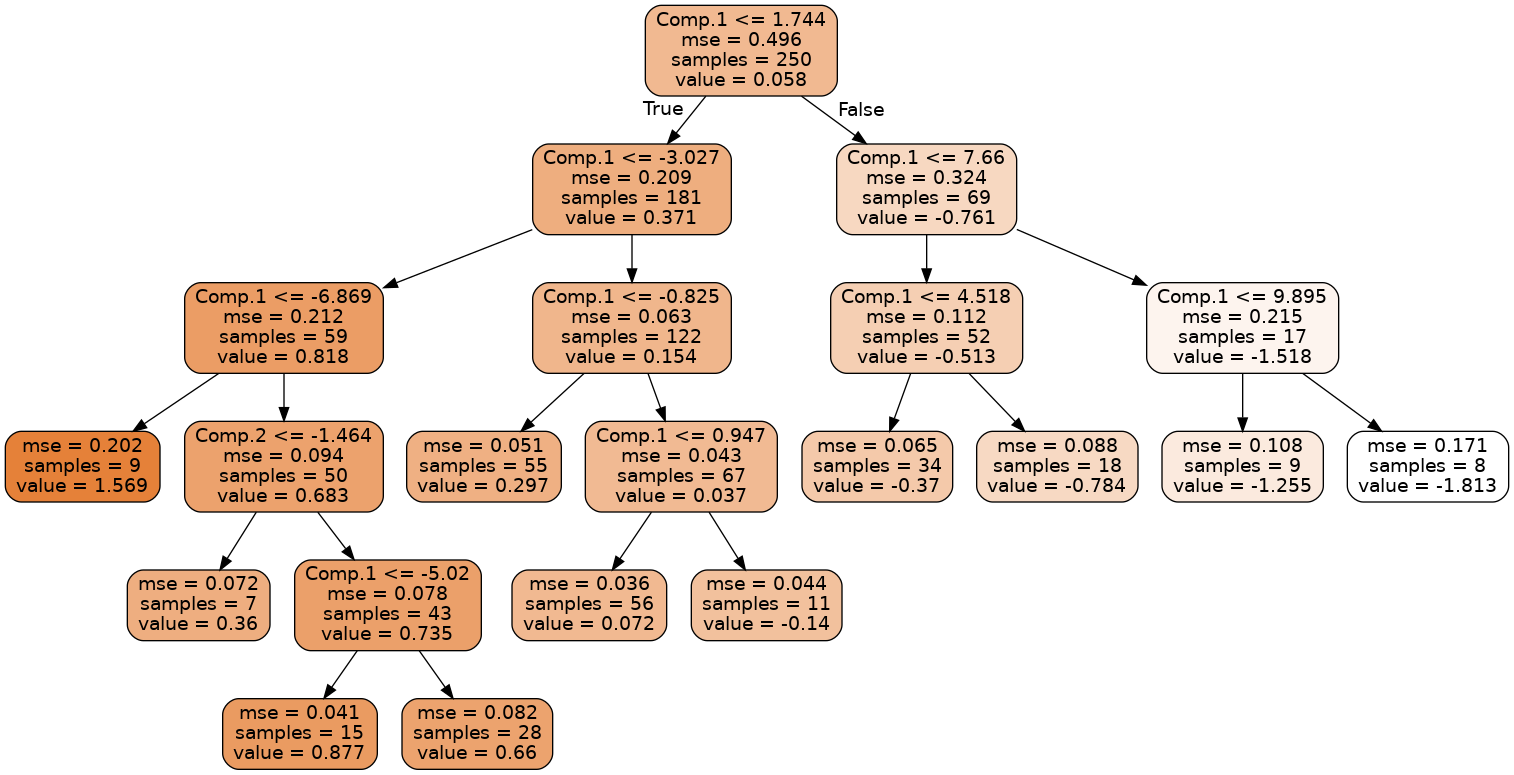

In [22]:
X,y = 100*SPYPortfFactors.drop('SPY',axis=1),100*SPYPortfFactors['SPY']
tsfit = DecisionTreeRegressor(random_state=0,max_leaf_nodes=11,min_samples_leaf=7)
tsfit.fit(X,y)
plot_tree(tsfit,list(X))

Example. Large Number of Predictors
-------------------------

Consider the example analysed in the workshop Linear Regression with Large Number of Predictors.     

Simulate data

In [23]:
N = 500
np.random.seed(0)
Epsilon = np.random.normal(size=N)
X = pd.DataFrame(np.random.normal(0, 2, size=(N,N))).add_prefix('X')
slopesSet = np.random.uniform(1,3,N)
Y = [1 + X.iloc[:,:z] @ slopesSet[:z] + Epsilon for z in np.arange(1,N)]
X.head(5)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X490,X491,X492,X493,X494,X495,X496,X497,X498,X499
0,0.765465,-0.068485,2.192694,-0.468432,-0.694901,-1.162537,-3.265269,-3.135535,-2.358316,2.602856,...,0.882066,0.357586,-1.598845,0.481575,0.578241,0.825742,-0.396798,0.188385,-2.295222,-0.716228
1,1.111925,1.784948,-0.844630,0.209428,0.456107,0.402960,1.081547,-3.636155,-0.098648,0.478067,...,-1.997698,-1.480274,-1.130996,0.952063,-4.316137,2.637102,-0.478593,-0.493587,-2.158686,-0.228451
2,0.026480,-0.243890,0.678119,-1.179264,-1.791632,1.096656,0.197335,0.394362,2.118055,-2.045129,...,2.685244,-1.479872,2.630275,-0.646915,0.395656,0.195502,2.803047,0.316868,-2.283803,-2.621941
3,-3.065842,-3.423940,0.092270,-1.916749,-0.161623,-1.407718,-1.541569,-0.961691,1.407171,1.858290,...,0.281621,0.946977,3.710492,2.831312,-0.605492,1.979359,1.171702,2.272776,1.343233,-1.948335
4,-3.239369,1.145254,3.805236,-1.551328,-0.376179,-2.071495,2.355659,-4.610334,-4.527321,0.750040,...,-0.681120,-2.606440,0.933501,0.322213,0.640064,4.158353,-1.814932,-0.384808,-2.425031,-0.161197


Fit linear regression model with 440 regressors.

In [24]:
m = 440
X,y = X.iloc[:,:m],Y[m-1]
lr = LinearRegression()

We reduced the number of regressors in order to ensure that on each iteration of 10-fold cross validation the number of regressors is less than the number of observations.  
The MSE of the model is

In [25]:
print ('Liner model CV MSE = ',-np.mean(cross_val_score(lr, X, y, 
                                        scoring='neg_mean_squared_error',cv=10)))

Liner model CV MSE =  44.68602716945257


Apply regression tree to these data.

In [26]:
dtr = DecisionTreeRegressor(random_state=0,min_samples_leaf=2)
print ('Decision Tree Regressor model CV MSE = ',-np.mean(cross_val_score(dtr, X, y, 
                                        scoring='neg_mean_squared_error',cv=10)))

Decision Tree Regressor model CV MSE =  14164.024785753287


Huge error. Let us try to optimize parameters

In [27]:
grid = {'max_depth':range(1,5), 'min_samples_leaf': range(1,6)}
regr = DecisionTreeRegressor(random_state=0)
# We set negative MSE as scoring function since GridSearchCV maximizes scoring. 
grid_search = GridSearchCV(regr, grid,cv=10, scoring = 'neg_mean_squared_error')
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))

Best: 7403.455762 using {'max_depth': 1, 'min_samples_leaf': 1}


Better, but far from linear model. The outputs show that trees can't handle this data at all.     
Linear method displayed much better predictive quality than trees in this example.    
Trees could not deal with this complex model with so many predictors. 


Discussion
=============

Claudia Perlich et al. presented a large-scale experimental comparison of trees and linear models methods in the paper [Tree Induction vs. Logistic Regression: A Learning-Curve Analysis](http://www.jmlr.org/papers/volume4/perlich03a/perlich03a.pdf).     
Authors examined several dozens large, two-class data sets, ranging from roughly one thousand examples to two million examples.    
The results of the study show the following.  

* Contrary to some prior observations, logistic regression does not generally outperform tree induction.
* More specifically, and not surprisingly, logistic regression is better for smaller training sets and tree induction for larger data sets. Importantly, this often holds for training sets drawn from the same domain (that is, the learning curves cross), so conclusions about induction-algorithm superiority on a given domain must be based on an analysis of the learning curves.
* Contrary to conventional wisdom, tree induction is effective at producing probability-based rankings, although apparently comparatively less so for a given training-set size than at making classifications. 
* The domains on which tree induction and logistic regression are ultimately preferable can be characterized surprisingly well by a  simple measure of the separability of signal from noise.